I need to fill the functions that I just used from the other files, create text explaining how to use the models, create the if statements for running the simulations or just plotting results from saved data. I think this may take 3 to 4 days, specially the explanation texts. After finishing this, I need to do a run of everything to make sure it works well. And them delete everything that it is not in this file, and put the dissertation original and the corrected version after I finishe subbitting the corrected version to the library with the links also for completeness of the repo, also put everything on zenodo and on github properly and with open code.

 # Imports

In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import qutip as qt
import scipy as scp
from tqdm.auto import tqdm
from functools import partial
from IPython.display import display
from fractions import Fraction
from core.utils import *
from core.models import *
from core.plot_funcs import *
# Create more bools for running or just loading data
run_ks = True
run_opt= True

# Utils

## Visuals of the plots

In [ ]:
default_area=mpl.rcParams['figure.figsize'][0]*mpl.rcParams['figure.figsize'][1]
new_figsize=[14,8]
mpl.rcParams['figure.figsize'] = new_figsize
mpl.rcParams['lines.linewidth']=5
mpl.rcParams['xtick.minor.visible']=True
mpl.rcParams['ytick.minor.visible']=True
mpl.rcParams['axes.grid']=True
mpl.rc('xtick', labelsize=18)           # x-tick numbers only
mpl.rc('ytick', labelsize=18)           # y-tick numbers only
mpl.rcParams['figure.dpi']=300

## How to fit functions using scipy

Fit parameters:
  A = 2.966 ± 0.029
  k = 0.5042 ± 0.011
  C = 0.4178 ± 0.013


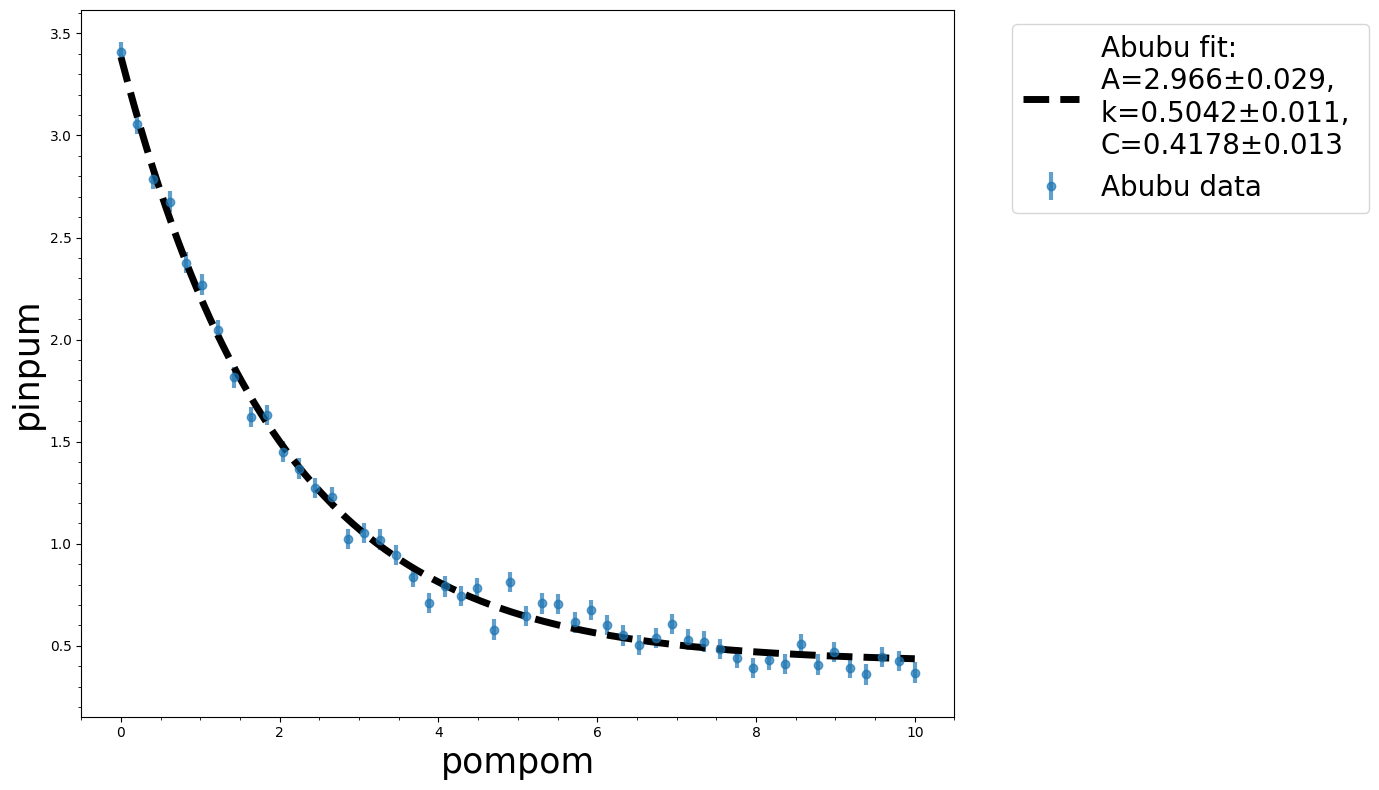

In [3]:
# -------------------------------------------------
# 1.  Load or create your x, y, and (optionally) sigma (y-errors)
xdata = np.linspace(0, 10, 50)
ydata = 3.0 * np.exp(-0.5 * xdata) + 0.4   # synthetic exact model
noise = 0.05 * np.random.randn(xdata.size)
ydata += noise                             # noisy data
sigma = np.full_like(ydata, 0.05)          # same error bar for all pts

# -------------------------------------------------
# 2.  Define the model = f(x, *params)
def my_model(x, A, k, C):
    """Exponential decay plus offset:  y = A * exp(-k x) + C"""
    return A * np.exp(-k * x) + C

# -------------------------------------------------
# 3.  Provide initial guesses for parameters
p0 = [1.0, 1.0, 0.0]       # [A_guess, k_guess, C_guess]
def fit_plot_data(func,x_data,y_data,fit_params,fit_guess,ax=None,errors=None,xaxis_label='x',yaxis_label='y',label='label'):
    # -------------------------------------------------
    #  Curve-fit
    if len(fit_params) != len(fit_guess):
        raise ValueError("Length of fit_params must match length of fit_guess")
    else:
        if errors is None:
            popt, pcov = scp.optimize.curve_fit(func, x_data, y_data, p0=fit_guess,maxfev=20000)
        else:
            popt, pcov = scp.optimize.curve_fit(func, x_data, y_data, p0=fit_guess, sigma=errors, 
                                                absolute_sigma=True,maxfev=20000)

        perr = np.sqrt(np.diag(pcov))   # 1σ uncertainties
        fitted_par={}
        print("Fit parameters:")
        for name, val, err in zip(fit_params, popt, perr):
            fitted_par[name]=(val,err)
            print(f"  {name} = {val:.4g} ± {err:.2g}")
        full_label=f"{label} fit: \n" + ", \n".join([f"{name}={val:.4g}±{err:.2g}" for name, val, err in zip(fit_params, popt, perr)])
        # -------------------------------------------------
        #  Evaluate fitted curve and plot
        xfit = np.linspace(x_data.min(), x_data.max(), 500)
        yfit = func(xfit, *popt)
        if ax is None:
            fig, ax = plt.subplots(figsize=(14,8))
        
        ax.errorbar(x_data, y_data, yerr=errors, fmt='o', label=f'{label} data', lw=3,alpha=0.7)
        ax.plot(xfit, yfit, 'k--', label=f'{full_label}', lw=5)
        ax.set_xlabel(xaxis_label,fontsize=25)
        ax.set_ylabel(yaxis_label,fontsize=25)
        ax.minorticks_on()
        ax.legend(bbox_to_anchor=(1.05, 1), loc="upper left",fontsize=20)
        
        return ax,fitted_par
fig, ax = plt.subplots(figsize=(14,8))
fit_plot_data(my_model, xdata, ydata, ['A', 'k', 'C'],p0, ax=ax,errors=sigma,label="Abubu",yaxis_label='pinpum',xaxis_label='pompom')
plt.tight_layout()
plt.show()

## Comparative Tables

In [4]:
def compare_regions(data1, data2, regions, labels=["A", "B", "C"]):
    """
    Compare two datasets over given index regions.
    
    Parameters:
        data1, data2 : array-like
            The datasets to compare (must be same length).
        regions : list of tuples
            Each tuple (start, end) defines a region.
        labels : list of str
            Labels for the regions (must match len(regions)).
    
    Returns:
        summary : list of dict
            Each dict contains region label, mean diff, std dev.
    """
    summary = []

    for (start, end), label in zip(regions, labels):
        seg1 = np.array(data1[start:end])
        seg2 = np.array(data2[start:end])
        diff = seg1 - seg2
        mean_diff = np.mean(np.abs(diff))
        std_diff = np.std(diff)
        rmse = np.sqrt(np.mean(diff**2))
        summary.append({
            "region": label,
            "mean_abs_diff": mean_diff,
            "std_dev_diff": std_diff,
            "rmse": rmse,
            "max_abs_diff": np.max(np.abs(diff)),
            "min_abs_diff": np.min(np.abs(diff))
            
        })

    return summary
# To print as a simple table:
def print_summary_table(summary):
    print(f"{'Region':<8} {'Mean Abs Diff':<15} {'Std Dev Diff':<15} {'RMSE':<15} {'Max Diff':<15} {'Min Diff':<15}")
    for entry in summary:
        print(f"{entry['region']:<8} {entry['mean_abs_diff']:<15.6f} {entry['std_dev_diff']:<15.6f} {entry['rmse']:<15.6f} {entry['max_abs_diff']:<15.6f} {entry['min_abs_diff']:<15.6f}")

## Contrast

In [5]:
def contrast(dynamics,init_state,exp,b_v,w_p_v,w_p_r,omR,readtime=3.0):
    """
    Function find S0 S1 contrast the dynamics of the system.
    """
    _,res=dynamics(10.0,init_state,b=B0(b_v,0.0,0.0),w_p=w_p_v,om_r=omR,
                      om=D_gs-mu_e*b_v,ti=0.0,mode="Laser",progress_bar="OFF")
    a=res.states[-1]
    t=res.times[-1]
    _,res=dynamics(1.0,a,b=B0(b_v,0.0,0.0),w_p=w_p_v,om_r=omR,
                      om=D_gs-mu_e*b_v,ti=t,mode="Free",progress_bar="OFF")
    a=res.states[-1]
    t=res.times[-1]
    _,res=dynamics(10.0,a,b=B0(b_v,0.0,0.0),w_p=w_p_r,om_r=omR,
                      om=D_gs-mu_e*b_v,ti=t,mode="Laser",progress_bar="OFF")
    wind=int(5000*readtime/10)
    s0=np.sum(qt.expect(exp,res.states[:wind]))
    s0_int=scp.integrate.simpson(qt.expect(exp,res.states[:wind]),res.times[:wind])
    s0_full=np.sum(qt.expect(exp,res.states))
    s0_int_full=scp.integrate.simpson(qt.expect(exp,res.states),res.times)
    _,res=dynamics(np.pi/omR,a,b=B0(b_v,0.0,0.0),w_p=w_p_v,om_r=omR,
                      om=D_gs-mu_e*b_v,ti=t,mode="MW",progress_bar="OFF")
    a=res.states[-1]
    t=res.times[-1]
    _,res=dynamics(10.0,a,b=B0(b_v,0.0,0.0),w_p=w_p_r,om_r=omR,
                      om=D_gs-mu_e*b_v,ti=t,mode="Laser",progress_bar="OFF")
    s1=np.sum(qt.expect(exp,res.states[:wind]))
    s1_int=scp.integrate.simpson(qt.expect(exp,res.states[:wind]),res.times[:wind])
    s1_full=np.sum(qt.expect(exp,res.states))
    s1_int_full=scp.integrate.simpson(qt.expect(exp,res.states),res.times)
    return s0,s1,s0_full,s1_full,s0_int,s1_int,s0_int_full,s1_int_full

## ODMRs

### CW - ODMR

### Pulsed - ODMR

### Comparative

## Ramsey